# Project 242

## Import

In [2]:
from backtester.backtesting import Strategy
from modules.data_preprocessing import *
from modules.add_features import *
from modules.metrics_prediction import *
from modules.metrics_performance import *
from modules.models import *
from modules.utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd

## I. Data

### 1. Load data

In [4]:
data = pd.read_csv('data/Binance_BTCUSDT_1h.csv')

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.637280e+12,2021-11-19 00:00:00,BTC/USDT,56891.62,57247.58,56674.00,57144.98,719.65701,4.099574e+07,19977.0
1,1.637276e+12,2021-11-18 23:00:00,BTC/USDT,56613.30,56987.57,56474.26,56891.62,2553.36240,1.447890e+08,76763.0


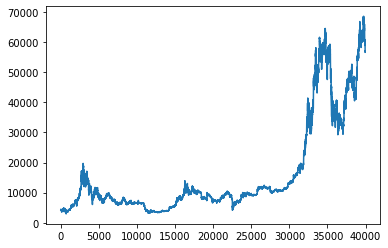

In [5]:
plt.plot(data[::-1].reset_index().close)
data.head(2)

### 2. Preprocess data

- clean data
- add features

In [6]:
# Clean data
data = clean_data(data)
data = data.rename(columns = {'Volume USDT': 'Volume'})
data.columns

Index(['open', 'high', 'low', 'close', 'Volume'], dtype='object')

Here, we can decide to add features ...

In [7]:
# Add features

data = add_technical_indicators(data, lookback_period=30)[30:]

In [8]:
data = data.drop(['VWAP'], axis = 1)

In [9]:
# Split data
train_data, test_data = split_data(data, split=0.25)

train_data = array_to_df(train_data, data.columns)
test_data = array_to_df(test_data, data.columns)

print(f'Shape X_train: {train_data.shape} | X_test: {test_data.shape}')

Shape X_train: (29936, 12) | X_test: (9978, 12)


In [10]:
# Scale data
#train_data, test_data = scale_data(train_data, test_data)

In [11]:
# Add Return
train_data = add_return(train_data)
test_data = add_return(test_data)

In [12]:
# Add Signal
#q_90 = np.quantile(abs(train_data.Return).iloc[:-1].values, 0.9)

train_data = add_signal(train_data, 0.001)
test_data = add_signal(test_data, 0.001)
#train_data['Signal'] = (train_data['Return'] >0).apply(int)
#test_data['Signal'] = (test_data['Return'] >0).apply(int)

In [13]:
train_pos, train_neg = round((train_data.Signal>0).sum()/train_data.Signal.shape[0],2)*100, round((train_data.Signal<0).sum()/train_data.Signal.shape[0],2)*100
test_pos, test_neg = round((test_data.Signal>0).sum()/test_data.Signal.shape[0],2)*100, round((test_data.Signal<0).sum()/test_data.Signal.shape[0],2)*100

print(f'Train set: 1 ({train_pos}%) | 0 ({100-(train_pos+train_neg)}%) | -1 ({train_neg}%)') 
print(f'Test set: 1 ({test_pos}%) | 0 ({100-(test_pos+test_neg)}%) | -1 ({test_neg}%)') 

Train set: 1 (38.0%) | 0 (26.0%) | -1 (36.0%)
Test set: 1 (42.0%) | 0 (19.0%) | -1 (39.0%)


In [14]:
#display(train_data.head(2))
#display(test_data.head(2))

In [15]:
train_data

,open,high,low,close,Volume,MOM,RSI,BB_high,BB_low,EMA,CCI,MACD,Return,Signal
30,4304.15,4371.52,4296.04,4356.31,2.234710e+05,-29.750833,53.271105,4462.289132,4215.078202,4318.454360,13.166937,-29.750833,-0.003673,-1
31,4356.31,4357.37,4302.72,4340.31,1.044750e+05,-20.882000,51.723613,4462.817545,4216.215788,4319.864401,1.766283,-20.882000,-0.000873,0
32,4340.31,4340.31,4287.79,4336.52,6.546818e+04,-15.141667,51.358028,4463.100965,4216.743702,4320.938956,-14.054429,-15.141667,-0.017187,-1
33,4331.71,4331.71,4221.05,4261.99,7.294201e+04,-16.511000,44.901817,4463.222261,4210.755739,4317.135797,-76.273927,-16.511000,-0.000608,0
34,4293.09,4293.09,4193.70,4259.40,3.026014e+05,-23.350333,44.699809,4462.519661,4204.705672,4313.410907,-99.718186,-23.350333,-0.005285,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29961,13118.24,13129.00,13083.35,13091.80,1.645348e+07,89.706000,60.958451,13163.531129,12877.361537,13040.775209,87.187880,89.706000,0.000000,0
29962,13118.24,13129.00,13083.35,13091.80,1.645348e+07,84.839333,60.958451,13168.439801,12880.925532,13044.067131,80.789714,84.839333,-0.002481,-1
29963,13091.80,13126.58,13031.46,13059.32,1.595781e+07,75.733000,56.569024,13169.715159,12887.154175,13045.051187,48.138417,75.733000,0.000000,0
29964,13091.87,13126.58,13031.46,13059.32,1.595781e+07,67.345667,56.569024,13170.539914,12893.833419,13045.971756,44.877483,67.345667,0.000705,0


## II. Model

### 1. Get data ready for models

In this section, the reformating of the data may depend on the model ...

In [16]:
train = prepare_data_2D_format(train_data)
test = prepare_data_2D_format(test_data, undersample = False)
test = test[:-10]

X_train = train
X_train = X_train.drop(['Signal'], axis = 1)
y_train = train['Signal']

X_test = test
X_test = X_test.drop(['Signal'], axis = 1)
y_test = test['Signal']

/Users/noemielevy/INDENG-242-project/modules/data_preprocessing.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(X), S, R


In [17]:
X_train

,open_day_minus10,high_day_minus10,low_day_minus10,close_day_minus10,Volume_day_minus10,MOM_day_minus10,RSI_day_minus10,BB_high_day_minus10,BB_low_day_minus10,EMA_day_minus10,...,low_day_minus1,close_day_minus1,Volume_day_minus1,MOM_day_minus1,RSI_day_minus1,BB_high_day_minus1,BB_low_day_minus1,EMA_day_minus1,CCI_day_minus1,MACD_day_minus1
0,8807.26,8844.00,8802.33,8810.28,7258435.18,-273.022667,29.828218,9425.124979,8717.193021,9019.536778,...,8815.71,8826.99,8293169.22,-138.783500,35.971361,9306.755804,8602.062196,8929.658348,-52.721928,-138.783500
1,4408.08,4625.85,4408.08,4580.00,142793.20,54.869667,64.484286,4458.014601,4219.454066,4353.888278,...,4564.77,4591.88,20794.15,142.162000,61.253438,4629.816779,4211.853887,4449.361851,125.374357,142.162000
2,5426.00,5510.00,5400.00,5500.40,22164357.30,150.433500,44.184404,5807.432405,4902.328928,5537.626375,...,5256.00,5387.61,42590864.23,-42.154667,44.256608,5679.336314,5125.356353,5456.658784,-18.229418,-42.154667
3,10395.98,10419.99,10310.00,10379.05,19028736.31,68.878333,56.529266,10402.888983,10213.381017,10323.907771,...,10296.68,10315.57,4276600.82,-13.036333,51.238872,10390.898620,10256.126047,10322.110552,-24.515960,-13.036333
4,7370.00,7435.00,7368.00,7421.88,15053867.20,45.698500,59.593511,7502.040422,7272.379578,7360.428764,...,7431.03,7458.27,7582871.65,62.256500,59.016192,7506.542442,7276.500225,7399.109849,83.102962,62.256500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23731,6595.06,6612.96,6592.25,6601.16,3270315.00,-32.725333,46.112067,6688.422082,6561.833251,6617.167627,...,6605.61,6618.51,1535524.81,10.615000,49.481520,6678.179883,6556.833450,6617.203568,-1.601916,10.615000
23732,6546.82,6555.99,6451.10,6457.98,12935329.55,-352.523167,30.857278,7319.071457,6433.777877,6796.525791,...,6188.00,6249.00,29006316.53,-274.427333,28.569779,7255.815306,6180.648027,6642.071523,-113.931947,-274.427333
23733,5945.01,6000.02,5945.01,6000.01,523087.86,9.362833,53.724257,6102.415786,5757.730880,5933.127711,...,5830.03,5879.97,605463.28,-33.666833,48.654897,6022.493634,5782.870366,5918.212162,-49.378661,-33.666833
23734,8089.00,8165.00,8000.01,8106.99,22284817.60,-212.435167,36.515765,8710.046777,8183.953889,8428.266487,...,7831.00,7880.00,9068167.17,-386.658333,32.508548,8782.633014,7796.379652,8216.745043,-128.229273,-386.658333


### 2. Build model

The ultimate goal of this section is to return a **prediction**.

This section may recquire a phase of **feature selection**.

...

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 100, max_leaf_nodes = 10)
gbc.fit(X_train, y_train)

In [ ]:
y_pred = gbc.predict(X_test)

### 3. Test prediction model

In [ ]:
TPR, FPR = 0, 0#get_TPR_FPR(y_test, y_pred)
F1 = 0#get_F1(y_test, y_pred)
ACC = get_ACC(y_test, y_pred)
WACC = 0#get_WACC(y_test, y_pred, test_data.close)

In [ ]:
models = ['Baseline']
metrics = ['TPR', 'FPR', 'ACC', 'F1', 'WACC']
metric_data = [[TPR, FPR, ACC, F1, WACC]]

pd.DataFrame(metric_data, index=models, columns=metrics)

### III. Strategy

### 1. Get data ready for backtesting

In [ ]:
# If the model used is a regression model on the return
#signal = get_signal(y_pred, alpha=q_90)

In [ ]:
signal = pd.Series(y_pred)
close = test_data.close
signal.describe()

In [ ]:
# Crop for better visualization
nb_days = 1

signal_crop = crop_window(signal, nb_days)
close_crop = crop_window(close, nb_days)

### 2. Backtesting

In [ ]:
strat = Strategy(cash=500, fees=0.001)

In [ ]:
strat.run(signal_crop, close_crop, verbose=False)

In [ ]:
wallet = np.array(strat.wallet)
profit_list = [0]
for i in range(1, len(wallet)):
    profit_list.append(wallet[i]-wallet[i-1])
    
profit = np.array(profit_list)

In [ ]:
strat.visualize()

### 3. Test performance startegy

In [ ]:
x_SharpeRatio = SharpeRatio(profit)
x_MaxDrawback = MaxDrawback(profit)
x_WinLossRatio = WinLossRatio(profit)
x_CumulativeProfit = CumulativeProfit(profit)
x_MeanProfit = MeanProfit(profit)

In [ ]:
models = ['Gradient Boosting']
metrics = ['SharpeRatio', 'MaxDrawback', 'WinLossRatio', 'CumulativeProfit', 'MeanProfit']
metric_data = [[x_SharpeRatio, x_MaxDrawback, x_WinLossRatio, x_CumulativeProfit, x_MeanProfit]]

pd.DataFrame(metric_data, index=models, columns=metrics)